In [1]:
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import sqlite3
from sklearn.linear_model import LinearRegression
geopandas.options.io_engine = "pyogrio"

conn = sqlite3.connect('db.sqlite3')
cursor = conn.cursor()

In [2]:
data = conn.execute(
"""
with attendances_month as (
select
    avg(data.value) as value,
    data.commune_id as commune_id,
    data.report_id as report_id,
    data.year || '-' || (
        case data.cohort
            when 'Enero' then '01'
            when 'Febrero' then '02'
            when 'Marzo' then '03'
            when 'Abril' then '04'
            when 'Mayo' then '05'
            when 'Junio' then '06'
            when 'Julio' then '07'
            when 'Agosto' then '08'
            when 'Septiembre' then '09'
            when 'Octubre' then '10'
            when 'Noviembre' then '11'
            when 'Diciembre' then '12'
        end
    ) || '-01' as date
from data
where cohort in ('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre')
and year > 2020
group by date, commune_id, report_id
),
aqi_month as (
select
    commune_id,
    date(datetime, 'unixepoch', 'start of month') as date, -- collapse entire month to first day of month
    avg(case when contaminant = 'CO' then concentration end)     as CO,
    avg(case when contaminant = 'MP10' then concentration end)  as MP10,
    avg(case when contaminant = 'MP2.5' then concentration end)  as MP25,
    avg(case when contaminant = 'NO' then concentration end)     as NO,
    avg(case when contaminant = 'NO2' then concentration end)    as NO2,
    avg(case when contaminant = 'NOx' then concentration end)    as NOx,
    avg(case when contaminant = 'O3' then concentration end)     as O3,
    avg(case when contaminant = 'SO2' then concentration end)    as SO2
from contaminant
group by date, commune_id
)
select
    commune.name as commune,
    report.description as report,
    attendances_month.date as date,
    attendances_month.value as value,
    aqi_month.CO as CO,
    aqi_month.MP10 as MP10,
    aqi_month.MP25 as MP25,
    aqi_month.NO as NO,
    aqi_month.NO2 as NO2,
    aqi_month.NOx as NOx,
    aqi_month.O3 as O3,
    aqi_month.SO2 as SO2,
    commune.income
from attendances_month
join aqi_month on aqi_month.date = attendances_month.date and aqi_month.commune_id = attendances_month.commune_id
join commune on commune.id = attendances_month.commune_id
join report on report.id = attendances_month.report_id
order by date;
""").fetchall()

data = pd.DataFrame(data, columns=['commune', 'report', 'date', 'value', 'CO', 'MP10', 'MP25', 'NO', 'NO2', 'NOx', 'O3', 'SO2', 'income'])
data

,commune,report,date,value,CO,MP10,MP25,NO,NO2,NOx,O3,SO2,income
0,LA CISTERNA,Número de Consultas Médicas por mes y Año,2021-01-01,1.500000,0.526,100.903226,27.586207,37.044306,23.140334,44.154964,NaN,2.254706,863400
1,LA CISTERNA,Ingresos Programa de Salud Mental por mes y año,2021-01-01,76.500000,0.526,100.903226,27.586207,37.044306,23.140334,44.154964,NaN,2.254706,863400
2,LA CISTERNA,Atenciones Remotas Salud Mental por mes y año,2021-01-01,337.333333,0.526,100.903226,27.586207,37.044306,23.140334,44.154964,NaN,2.254706,863400
3,LA CISTERNA,Consultas Médicas Especialidad Salud Mental po...,2021-01-01,3.000000,0.526,100.903226,27.586207,37.044306,23.140334,44.154964,NaN,2.254706,863400
4,LA CISTERNA,Atenciones del Programa de Salud Mental por me...,2021-01-01,269.000000,0.526,100.903226,27.586207,37.044306,23.140334,44.154964,NaN,2.254706,863400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,QUILICURA,Consultas Médicas Especialidad Salud Mental po...,2024-08-01,1.000000,NaN,125.434783,53.040000,NaN,NaN,NaN,NaN,NaN,863021
1758,QUILICURA,Atenciones del Programa de Salud Mental por me...,2024-08-01,875.125000,NaN,125.434783,53.040000,NaN,NaN,NaN,NaN,NaN,863021
1759,TALAGANTE,Ingresos Programa de Salud Mental por mes y año,2024-08-01,19.500000,NaN,100.500000,48.571429,NaN,NaN,NaN,NaN,NaN,869862
1760,TALAGANTE,Consultas Médicas Especialidad Salud Mental po...,2024-08-01,2.000000,NaN,100.500000,48.571429,NaN,NaN,NaN,NaN,NaN,869862


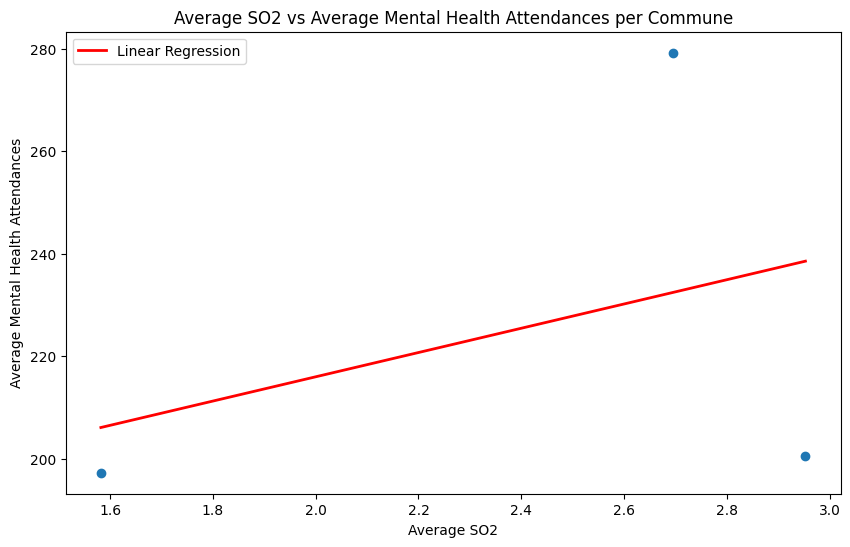

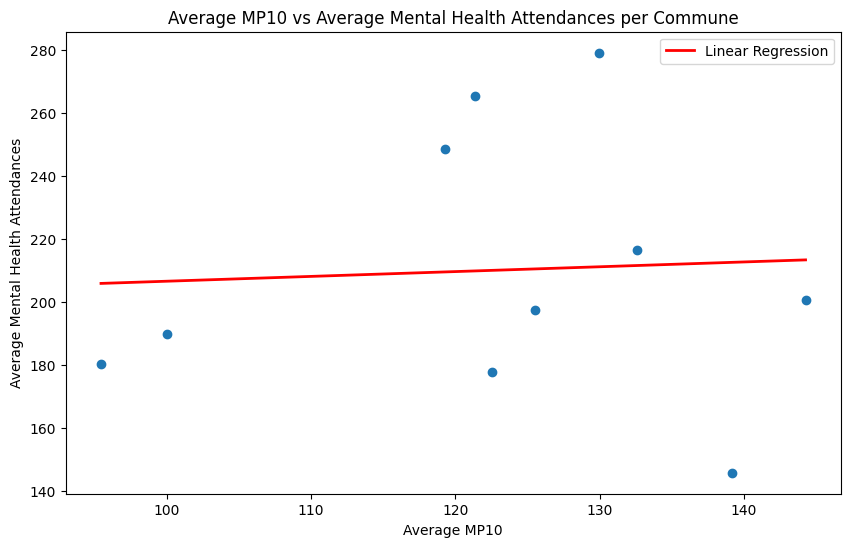

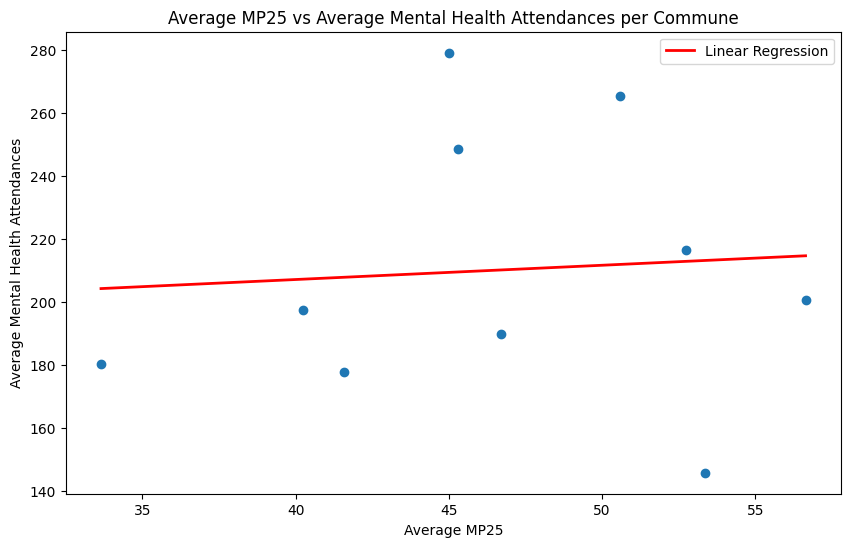

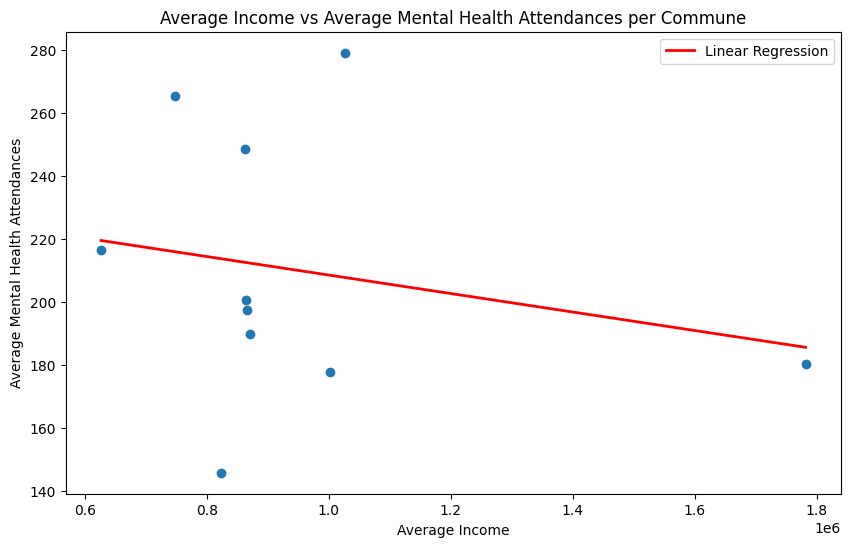

In [4]:
# get average so2 and value per commune
communes_so2_avg = data[['commune', 'value', 'SO2']].groupby('commune').mean().reset_index().dropna()
# linear regression
X = communes_so2_avg[['SO2']]
y = communes_so2_avg['value']
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(communes_so2_avg['SO2'], communes_so2_avg['value'])
ax.set_xlabel('Average SO2')
ax.set_ylabel('Average Mental Health Attendances')
# plot regression line
x_range = pd.DataFrame({'SO2': [communes_so2_avg['SO2'].min(), communes_so2_avg['SO2'].max()]})
y_range = model.predict(x_range)
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Linear Regression')
ax.legend()
ax.set_title('Average SO2 vs Average Mental Health Attendances per Commune')
plt.show()

# get average mp10 and value per commune
communes_mp10_avg = data[['commune', 'value', 'MP10']].groupby('commune').mean().reset_index().dropna()
# linear regression
X = communes_mp10_avg[['MP10']]
y = communes_mp10_avg['value']
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(communes_mp10_avg['MP10'], communes_mp10_avg['value'])
ax.set_xlabel('Average MP10')
ax.set_ylabel('Average Mental Health Attendances')
# plot regression line
x_range = pd.DataFrame({'MP10': [communes_mp10_avg['MP10'].min(), communes_mp10_avg['MP10'].max()]})
y_range = model.predict(x_range)
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Linear Regression')
ax.legend()
ax.set_title('Average MP10 vs Average Mental Health Attendances per Commune')
plt.show()

# get average mp25 and value per commune
communes_mp25_avg = data[['commune', 'value', 'MP25']].groupby('commune').mean().reset_index().dropna()
# linear regression
X = communes_mp25_avg[['MP25']]
y = communes_mp25_avg['value']
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(communes_mp25_avg['MP25'], communes_mp25_avg['value'])
ax.set_xlabel('Average MP25')
ax.set_ylabel('Average Mental Health Attendances')
# plot regression line
x_range = pd.DataFrame({'MP25': [communes_mp25_avg['MP25'].min(), communes_mp25_avg['MP25'].max()]})
y_range = model.predict(x_range)
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Linear Regression')
ax.legend()
ax.set_title('Average MP25 vs Average Mental Health Attendances per Commune')
plt.show()

# income
communes_income_avg = data[['commune', 'value', 'income']].groupby('commune').mean().reset_index().dropna()
# linear regression
X = communes_income_avg[['income']]
y = communes_income_avg['value']
model = LinearRegression()
model.fit(X, y)
r_squared = model.score(X, y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(communes_income_avg['income'], communes_income_avg['value'])
ax.set_xlabel('Average Income')
ax.set_ylabel('Average Mental Health Attendances')
# plot regression line
x_range = pd.DataFrame({'income': [communes_income_avg['income'].min(), communes_income_avg['income'].max()]})
y_range = model.predict(x_range)
ax.plot(x_range, y_range, color='red', linewidth=2, label=f'Linear Regression')
ax.legend()
ax.set_title('Average Income vs Average Mental Health Attendances per Commune')
plt.show()